In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import matplotlib.ticker as ticker
import re
import numpy as np
from IPython.display import display, HTML
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams["legend.loc"] = 'upper right' 

# plot


In [2]:
def display_table_resluts(logs,columns =['type','probability','threshold','B_1','B_45','B_52'], col_to_format =  ['B_1','B_45','B_52']):
    table = logs[columns]
    for col in col_to_format:
        table[col] = table[col].apply(lambda x : '{:.2f}'.format(x))
    display(HTML(table.to_html()))
    return table

In [3]:
mapper = dict(zip(["<class 'river.forest.adaptive_random_forest.ARFClassifier'>",
 "<class 'river.tree.hoeffding_adaptive_tree_classifier.HoeffdingAdaptiveTreeClassifier'>",
 "<class 'river.naive_bayes.gaussian.GaussianNB'>", "<class 'river.dummy.PriorClassifier'>"],['ARF','HT','NB','Majority']))

In [23]:
def create_partial_plot(method,dataset,tmp,descriptive_vars,types,agg_type,metric,with_saving, title):
    tmp['types_of_data'] = tmp.apply(lambda r: "_".join([str(r[col]) if not pd.isna(r[col]) else "" for col in descriptive_vars ]) ,axis =1)
    tmp = tmp.replace(" ",None)
    tmp = tmp[tmp['type'].apply(lambda x : x in types)]
    tmp = tmp.drop(columns=descriptive_vars)
    tmp = tmp.melt(id_vars = 'types_of_data')
    tmp = tmp.rename(columns = {'types_of_data':'threshold'})
    tmp['variable'] = tmp['variable'].apply(lambda x : x.split('_')[1])
    if agg_type == 'labelled instances':
        tmp['variable'] = 100*tmp['variable'].astype(int) #.rolling(10,min_periods=1).mean()
    tmp['threshold'] = tmp['threshold'] .apply(lambda x: x.split('_')[1])
    fig, ax = plt.subplots(1,1,figsize=(15,2), sharey=True,sharex=True)  
    g = sns.lineplot(data = tmp, x = 'variable', y = 'value',hue = 'threshold',ax = ax,palette='tab10')   
    g.set(ylim=(0, 1),ylabel= metric,xlabel=agg_type)   

    if with_saving:
        plt.savefig(os.path.join('images',dataset,method,f"{title}.pdf"), format="pdf", bbox_inches="tight")
    plt.show()
    # else:
    #     g.set(ylim=(0, 1),ylabel= metric,xlabel=agg_type,xticklabels=[])
    

    


In [21]:
def plot_bins_diff(logs,method,dataset, agg_type = "bins",metric = 'Acc',types = ['ssl','delay'], filter = None, descriptive_vars = [],
                    with_saving = False, save_table = False, columns_of_table = ['type','probability','B_1','B_45','B_52']):
    to_keep = [d for d in descriptive_vars]
    if filter:
        to_keep.append(filter)
    logs = logs.sort_values(by = to_keep)
    if agg_type == 'bins':
        to_keep.extend([x for x in logs.columns if x.startswith("B_")])
    elif agg_type == 'labelled instances':
        to_keep.extend([x for x in logs.columns if x.startswith("m_")])
    partial_logs = logs[to_keep]

    if filter is None:
        fig, ax = plt.subplots(1,1,figsize=(15,2), sharey=True,sharex=True)
        plt.grid(axis = 'x')
        fig.tight_layout()
        create_partial_plot(ax,partial_logs,descriptive_vars,types,agg_type,metric,with_saving, 0)
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 0.9), ncol=4, title=None, frameon=False)
    else:
        filters = [f  for f  in partial_logs[filter].unique() if not pd.isna(f)]
        # fig, ax = plt.subplots(len(filters),1,figsize=(15,2*len(filters)), sharey=True,sharex=False)
        # fig.tight_layout()
        if len(filters) == 1:
            create_partial_plot(method,dataset,partial_logs,descriptive_vars,types,agg_type,metric,with_saving,filters[0])
            # sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 0.9), ncol=4, title=None, frameon=False)
        else:
            for i,f in enumerate(filters):
                tmp = partial_logs[partial_logs[filter]==f]
                tmp = tmp.drop(columns =[filter])
                create_partial_plot(method,dataset,tmp,descriptive_vars,types,agg_type,metric,with_saving,f)
                # ax[i].set_title(f)
                # ax[i].grid(axis = 'x')
                # if i>0:
                #     ax[i].legend([],[], frameon=False)
                # else:
                #     sns.move_legend(ax[i], "lower center", bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=False)
            

 
    # plt.suptitle(title, size=16, y=1.2)
    # if with_saving:
    #     plt.savefig(os.path.join('images',dataset,f"{title}_{agg_type}_{metric}_{'_'.join(types)}.pdf"), format="pdf", bbox_inches="tight")
    # plt.show()
    if save_table:
        table = display_table_resluts(logs,columns =columns_of_table)
    return table

In [87]:
def create_partial_plot_classifers_comp(tmp,id_column,agg_type,metric, dataset,filter,with_saving):
    tmp = tmp.melt(id_vars = id_column)
    tmp['variable'] = tmp['variable'].apply(lambda x : x.split('_')[1])
    if agg_type == 'labelled instances':
        tmp['variable'] = 100*tmp['variable'].astype(int) #.astype(int).rolling(6,min_periods=1).mean()
    tmp = tmp[tmp['value']!=' ']
    fig, ax = plt.subplots(1,1,figsize=(15,2), sharey=True,sharex=True) 
    
    g = sns.lineplot(data = tmp, x = 'variable', y = 'value',hue = id_column,palette='tab10', ax = ax)   
    all_vars = tmp['variable'].unique()
    all_vars =all_vars[::int(len(all_vars)/10)]
    g.set(ylim=(0, 1),ylabel= metric,xlabel=agg_type,xticks  = all_vars)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=False)
    if with_saving:
        directory = os.path.join('images','method comparison',dataset)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(os.path.join(directory,f"{filter}.pdf"), format="pdf", bbox_inches="tight")
    plt.show()

In [88]:
def plot_method_comparison(logs,dataset, agg_type = "bins",metric = 'Acc', filter = 'classifier', descriptive_var = 'type_and_probability',
                    with_saving = False, save_table = False, columns_of_table = ['type_and_probability','probability','B_1','B_45','B_52']):
    to_keep = [ descriptive_var]
    if filter:
        to_keep.append(filter)
    logs = logs.sort_values(by = to_keep)
    if agg_type == 'bins':
        to_keep.extend([x for x in logs.columns if x.startswith("B_")])
    elif agg_type == 'labelled instances':
        to_keep.extend([x for x in logs.columns if x.startswith("m_")])
    partial_logs = logs[to_keep]

    filters = [f  for f  in partial_logs[filter].unique() if not pd.isna(f)]
    #fig, ax = plt.subplots(len(filters),1,figsize=(15,2*len(filters)), sharey=True,sharex=True)
    #fig.tight_layout()
    for i,f in enumerate(filters):
        tmp = partial_logs[partial_logs[filter]==f]
        # if 'lfs' in f or 'init' in f:
        #     tmp = tmp.drop_duplicates(subset = ['classifier' ])
        tmp = tmp.drop(columns =[filter])
        create_partial_plot_classifers_comp(tmp,descriptive_var,agg_type,metric,dataset,f, with_saving) 
        # ax[i].set_title(f)
        # if i>0:
        #     ax[i].legend([],[], frameon=False)
        # else:
        #     sns.move_legend(ax[i], "lower center", bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=False)
        

 
    # plt.suptitle(title, size=16, y=1.2)
    # if with_saving:
    #     plt.savefig(os.path.join('images',dataset,f"{title}_{agg_type}_{metric}_{'_'.join(types)}.pdf"), format="pdf", bbox_inches="tight")
    # plt.show()
    # if save_table:
    #     table = display_table_resluts(logs,columns =columns_of_table)
    # return table

In [10]:
types = ['ssl','init']
thresholds = [0.7,0.5,1,0.9]
probabilities = [0.1,0.5,0.2]

In [101]:
pd.read_csv(os.path.join("logs_formatted",dataset,f"{method}.csv"))

,stream,hyperparameters,date,type,probability,B,frequency,B_1,B_2,B_3,...,m_190,m_191,m_192,m_193,m_194,m_195,m_196,m_197,m_198,m_199
0,LED_abrubt_constant_delay_lfs_0.6_0_20000,"{'n_models': '10', 'max_features': '5', 'lambd...",06-May-23 11:20:21,lfs,0.60,50,100,0.000000,0.000000,0.000000,...,,,,,,,,,,
1,LED_abrubt_constant_delay_lfs_0.6_0_20000,"{'n_models': '10', 'max_features': '5', 'lambd...",06-May-23 11:23:19,lfs,0.60,50,100,0.000000,0.000000,0.000000,...,,,,,,,,,,
2,initail_LED_Drift_abrubt,"{'n_models': '10', 'max_features': '5', 'lambd...",06-May-23 11:24:36,init,NaN,50,100,0.000000,0.000000,0.000000,...,0.75,0.8,0.72,0.75,0.78,0.73,0.68,0.84,0.81,0.71
3,LED_abrubt_constant_delay_lfs_0.6_0_20000,"{'n_models': '10', 'max_features': '5', 'lambd...",06-May-23 11:26:32,lfs,0.60,50,100,0.000000,0.000000,0.000000,...,,,,,,,,,,
4,LED_abrubt_constant_delay_lfs_0.75_0_20000,"{'n_models': '10', 'max_features': '5', 'lambd...",06-May-23 11:28:53,lfs,0.75,50,100,0.000000,0.000000,0.000000,...,,,,,,,,,,
5,LED_abrubt_constant_delay_lfs_0.75_0_20000,"{'n_models': '10', 'max_features': '5', 'lambd...",06-May-23 11:31:01,lfs,0.75,50,100,0.000000,0.000000,0.000000,...,,,,,,,,,,
6,initail_LED_Drift_abrubt,"{'n_models': '10', 'max_features': '5', 'lambd...",06-May-23 11:32:45,init,NaN,50,100,0.000000,0.000000,0.000000,...,0.75,0.8,0.72,0.75,0.78,0.73,0.68,0.84,0.81,0.71
7,LED_abrubt_constant_delay_lfs_0.75_0_20000,"{'n_models': '10', 'max_features': '5', 'lambd...",06-May-23 11:33:09,lfs,0.75,50,100,0.000000,0.000000,0.000000,...,,,,,,,,,,
8,initail_LED_Drift_abrubt,"{'n_models': '10', 'max_features': '5', 'lambd...",06-May-23 11:40:38,init,NaN,50,100,0.000000,0.000000,0.000000,...,0.8,0.8,0.74,0.77,0.82,0.76,0.74,0.82,0.76,0.72
9,LED_abrubt_constant_delay_lfs_0.9_0_20000,"{'n_models': '10', 'max_features': '5', 'lambd...",06-May-23 11:41:25,lfs,0.90,50,100,0.000000,0.000000,0.000000,...,,,,,,,,,,


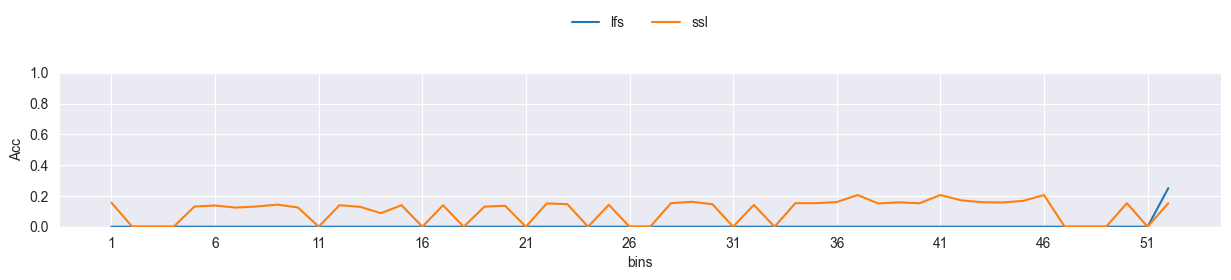

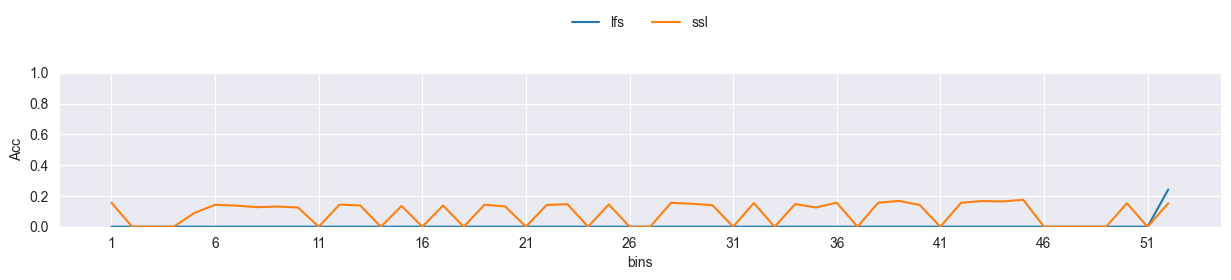

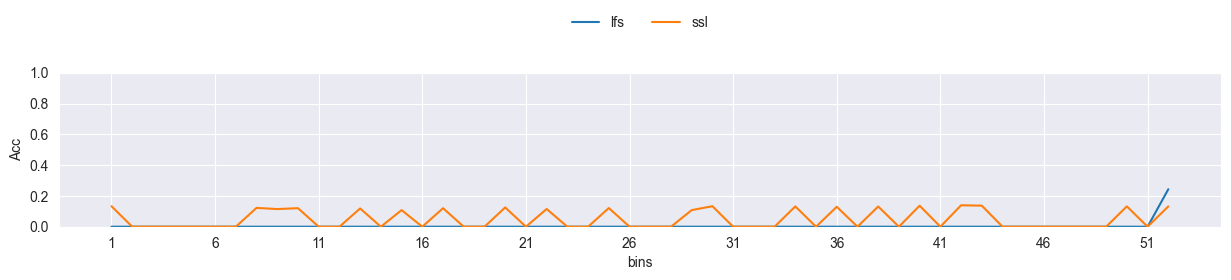

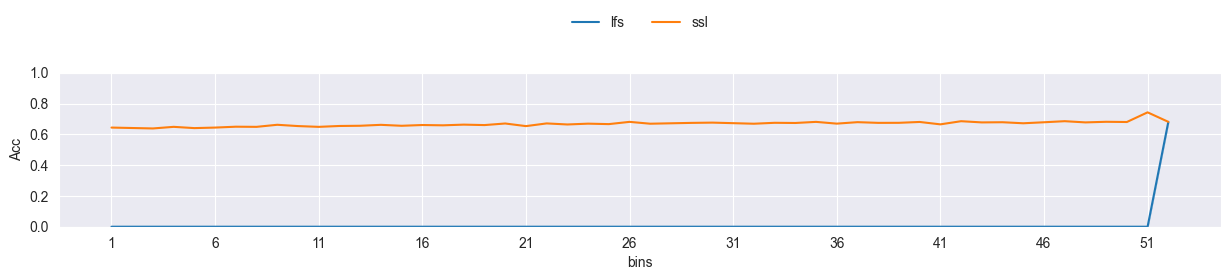

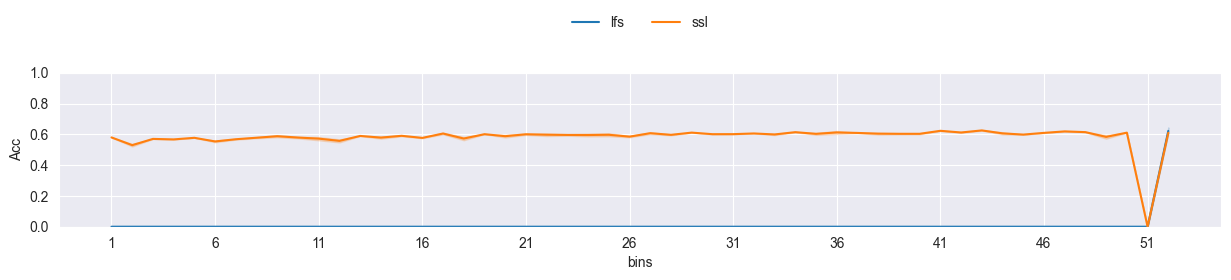

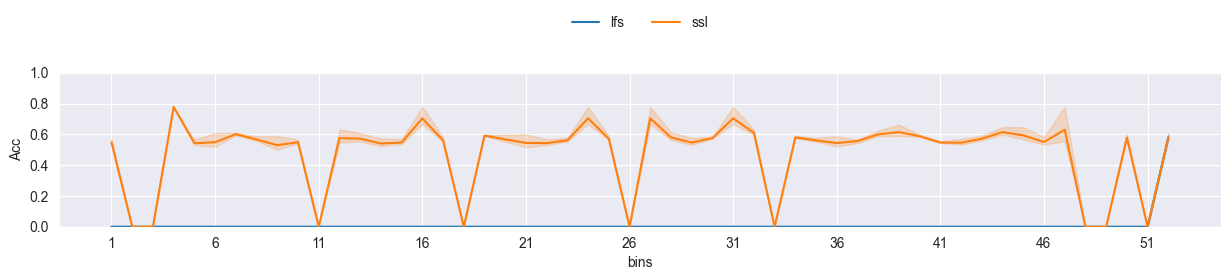

In [114]:
mpl.rcParams["legend.loc"] = 'best' 

for dataset in ['LED_abrupt']:
    method_logs = pd.DataFrame()
    try:
        for method in ['CluStream']:
            logs = pd.read_csv(os.path.join("logs_formatted",dataset,f"{method}.csv"))
            logs['classifier']=method
            if method == 'HT_with_params':
                 continue
                 logs['classifier'] = 'HT_max_depth_10'
            logs['hyperparameters'] = logs['hyperparameters'].apply(eval)
            # if method in    ['ARF','HT','NB','HT_with_params']    :           
            #         logs = logs[logs['threshold'].apply(lambda t: t  in [0.7])]
            # logs = logs[logs['type'].apply(lambda t: t  in types)]
            # # 
            # logs= logs[logs['probability'].apply(lambda x : x in probabilities)]
            method_logs = pd.concat([method_logs, logs], axis = 0)

                
                
    
        
        #method_logs = method_logs[method_logs['type'].apply(lambda x : x in ['delay','init'])]
        #method_logs = method_logs[method_logs['threshold'].apply(lambda x : x in [0.8])]
        # method_logs['type_and_proba'] = method_logs['type'].astype(str) +' '+  method_logs['probability'].fillna("").astype(str)
        # method_logs['type_and_threshold'] = method_logs['type'].astype(str) +' '+  method_logs['threshold'].fillna("").astype(str)
        #method_logs = method_logs[((method_logs['probability'] == 0.5) | method_logs['probability'].isna() ) & (method_logs['type'].apply(lambda x : x =='ssl' or x =='delay'))]
        #method_logs = method_logs[method_logs['threshold']!=1]

        plot_method_comparison(logs = method_logs,dataset = dataset, agg_type = 'bins', with_saving=True,save_table=False,descriptive_var ='type',filter = 'probability')
    except Exception as e:
        print(e,dataset, method)
    
   

In [113]:
for dataset in ['LED_abrupt']:
    for  method in ['CluStream.csv']:

        try:
            print(method,dataset)
            logs = pd.read_csv(os.path.join("logs_formatted",dataset,f"{method}"))
            #logs = logs[logs['threshold'].apply(lambda x: x in [0.9,0.7,0.5,1.0])]
            # logs = logs[logs['probability'].apply(lambda x: x in [0.5,0.2,0.1])]
            # logs = logs.sort_values('threshold')
            # logs['threshold'] = logs.apply(lambda x: None if x['type']=='lfs' else x['threshold'],axis =1)
            # logs = logs.drop_duplicates(subset = ['type','threshold','probability'])
            directory = os.path.join('images',dataset,method[:-4])
            if not os.path.exists(directory):
                os.makedirs(directory)
            table = plot_bins_diff(logs = logs,method = method[:-4],dataset = dataset,agg_type = 'labelled instances',types=types, with_saving=True,save_table=False,descriptive_vars =['type'], filter = 'probability')
        except Exception as e:
            print(e)
            pass
        

CluStream.csv LED_abrupt
list index out of range


In [108]:
logs['probability'].value_counts()

probability
0.90    6
0.75    5
0.60    4
Name: count, dtype: int64

# Histograms

In [59]:
os.listdir('distribution')

['ARF_LED_abrubt.pkl',
 'big_comaprison_1805.pkl',
 'cover05-1.pkl',
 'cover07.pkl',
 'cover09.pkl',
 'covermajority.pkl',
 'covertype_2005.pkl',
 'CoverType_mymethod.pkl',
 'LED_abrubt1.pkl',
 'LED_abrubt_high_probas.pkl',
 'LED_gradual1.pkl',
 'my_method.pkl',
 'RBF_fast_1.pkl',
 'RBF_fast_1_0.5.pkl',
 'RBF_HT_with_depth.pkl',
 'RBF_moderate_1.pkl',
 'rbf_moderate_1805.pkl',
 'test.pkl']

In [62]:
import pickle

# save dictionary to person_data.pkl file
with open(f'distribution\\rbf_moderate_1805.pkl', 'rb') as fp:
    res = pickle.load(fp)

In [56]:
def plot_histograms(res, with_saving = False):
    for q,streams in res.items():
        for stream in streams:
            stream_name = stream[0]
            if 'lfs' not in stream_name and 'init' not in stream_name:
                fig, ax = plt.subplots(1,len(stream[1]),figsize=(5*len(stream[1]),4),sharex=True) 
                if len(stream[1]) ==1:
                    method_name = list(stream[1].keys())[0]
                    method = list(stream[1].values())[0]
                    ax.hist(method[2],bins = 10)
                    ax.set_title(method_name)
                    ax.set(ylabel = "Number of instances",xlabel = "Prediction confidence")
                else:
                    for i,(method_name,method) in enumerate(stream[1].items()):
                        ax[i].hist(method[2],bins = 10)
                        ax[i].set_title(method_name)
                        if i ==0:
                            ax[i].set(ylabel = "Number of instances",xlabel = "Prediction confidence")
                        else:
                            ax[i].set(ylabel = "",xlabel = "Prediction confidence")
                plt.suptitle(stream_name, size=16, y=1)  
                if with_saving:     
                    plt.savefig(os.path.join('distribution_plots',f'{stream_name+";"+";".join([k for k in stream[1].keys()])}.pdf'), format="pdf", bbox_inches="tight")
                plt.show()

In [53]:
def plot_histogramsfor_method(res,method_name, folder = '',with_saving = False):
    for q,streams in res.items():
        streams_used = [s for s in streams if 'lfs' not in s[0] and 'init'not in s[0]]
        # fig, ax = plt.subplots(1,len(streams_used),figsize=(5*len(streams_used),4), sharex=True) 
        for i,stream in enumerate(streams_used):
            stream_name =  re.search('(delay(_ssl_\d.\d+)?)',stream[0]).group(1)
            method = stream[1][method_name]
            g = sns.histplot(method[2],bins = 20)
            g.set(ylabel = "Number of instances",xlabel = "Prediction confidence")
            if with_saving: 
                directory  = os.path.join('distribution_plots',folder)
                if not os.path.exists(directory):
                    os.makedirs(directory)    
                plt.savefig(os.path.join(directory,f'{stream_name}.pdf'), format="pdf", bbox_inches="tight")
            plt.show()

In [82]:
res[(0, 20000)][1][1]['ARF1']

3

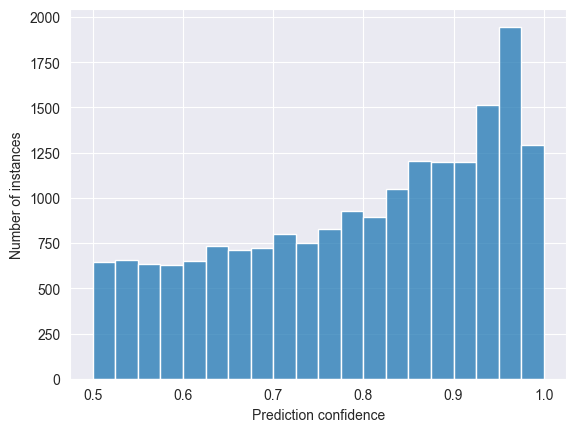

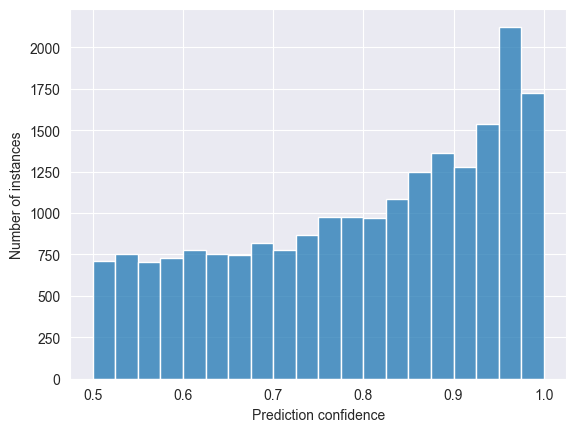

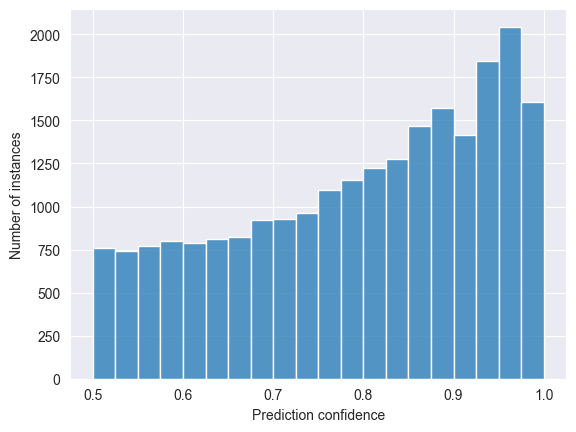

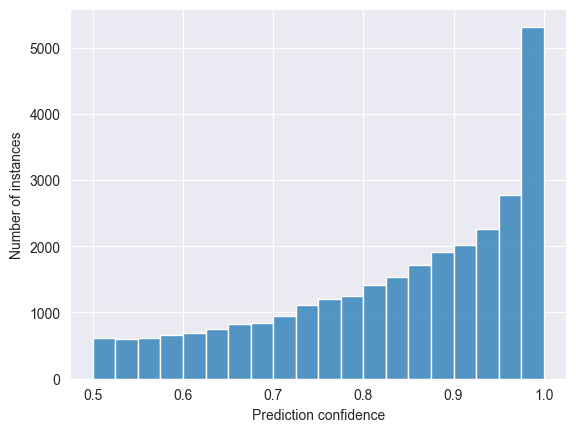

In [66]:
plot_histogramsfor_method(res, 'ARF07',"ARF threshold 0.7 - RBF moderate",True)

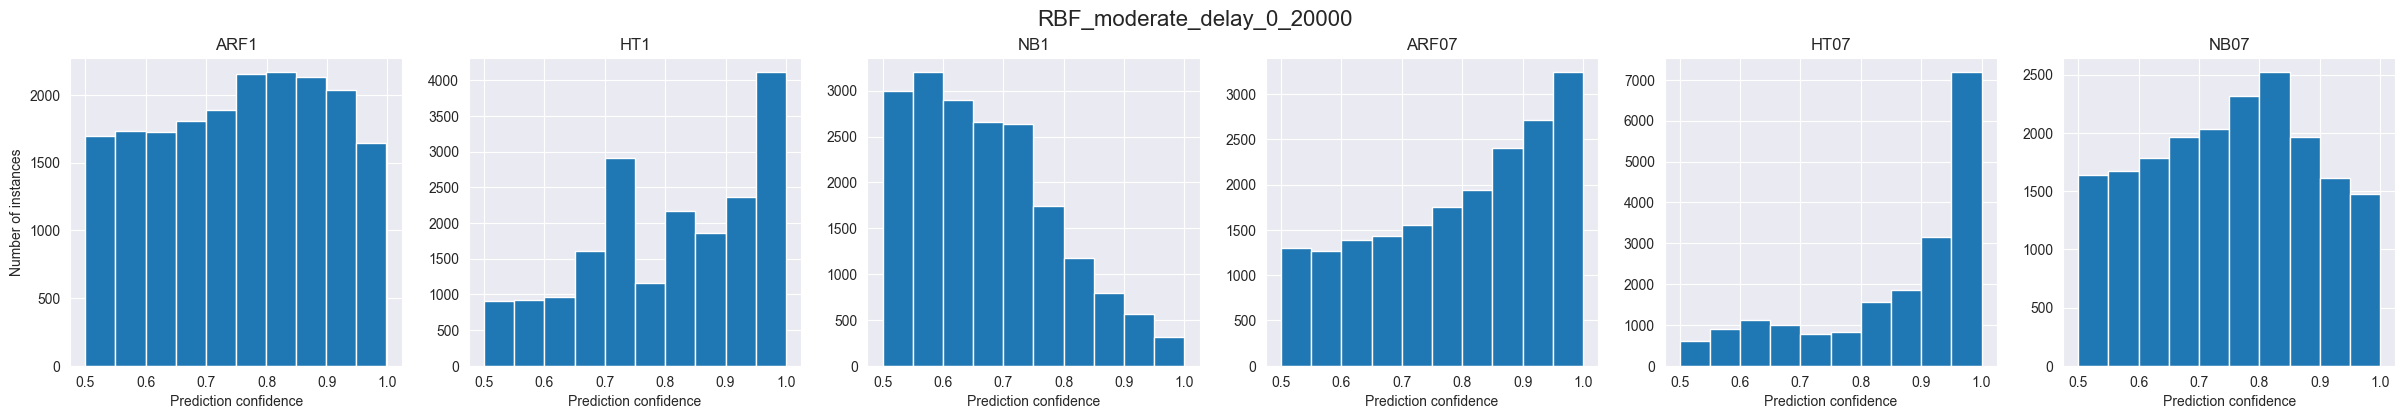

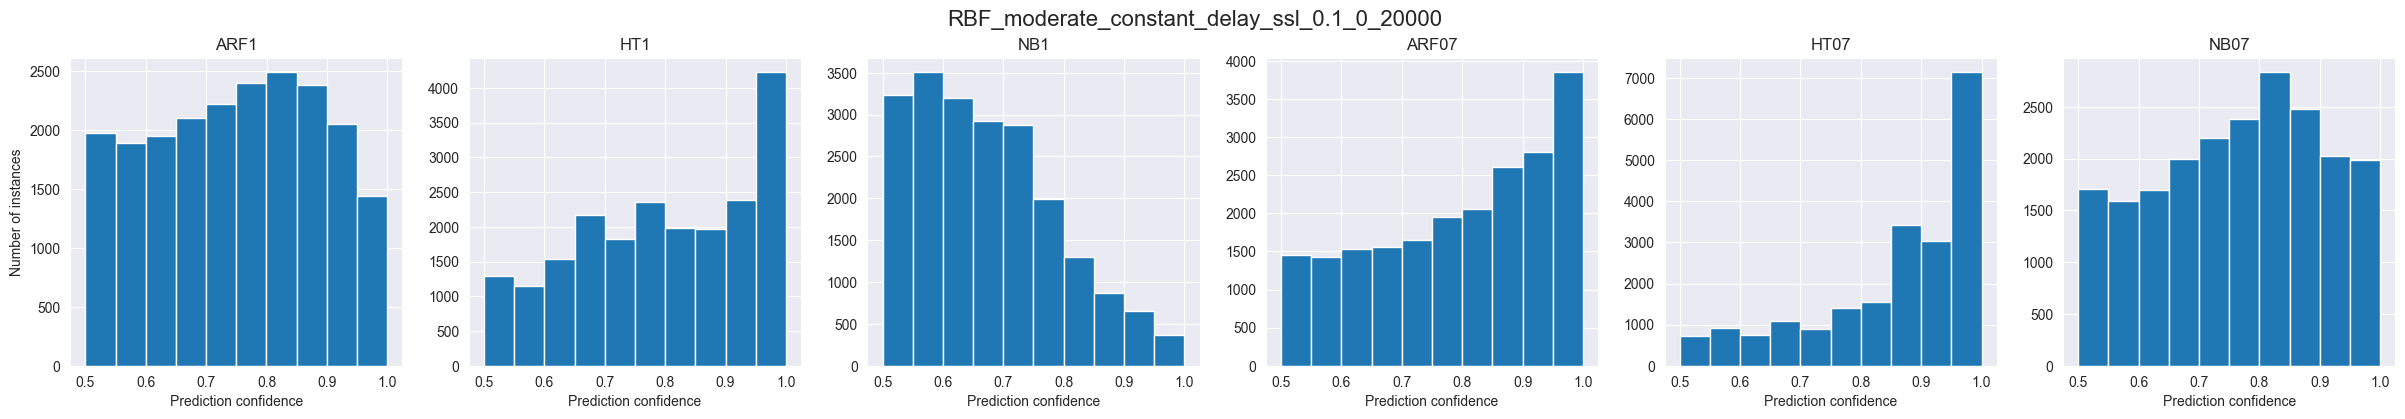

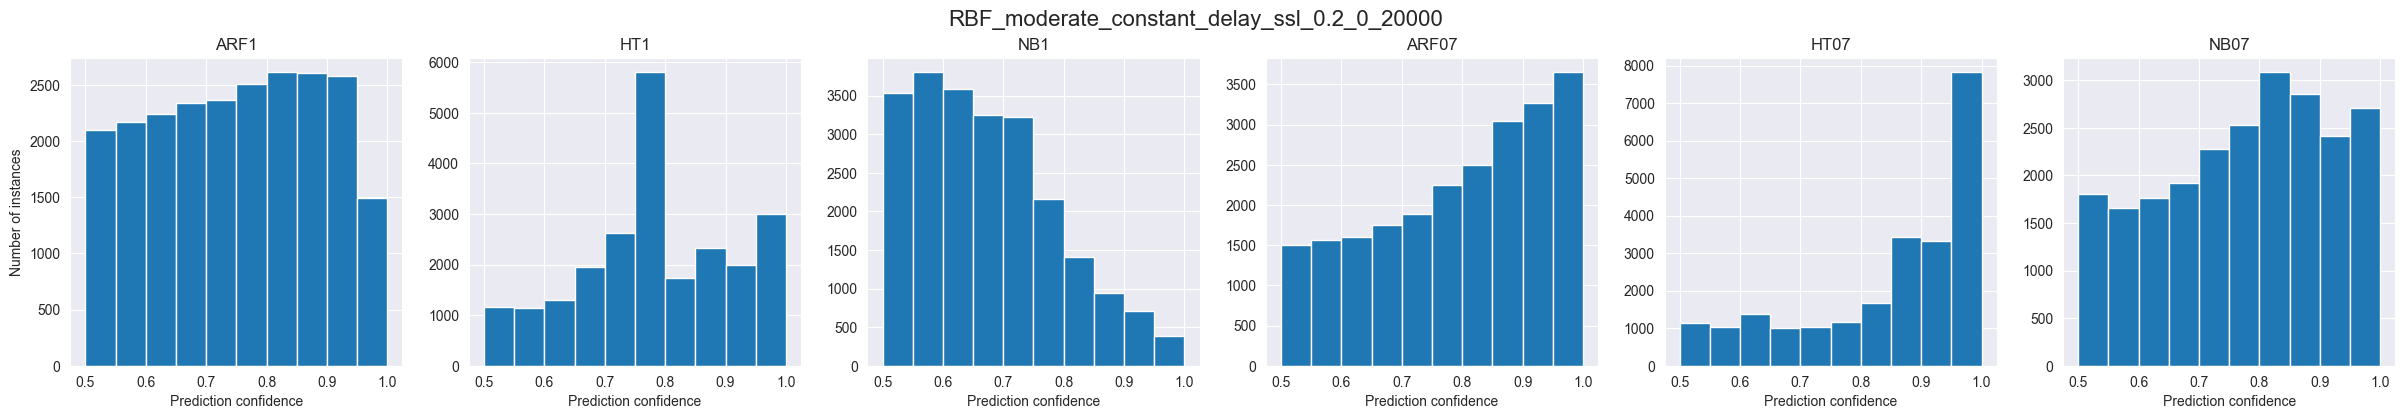

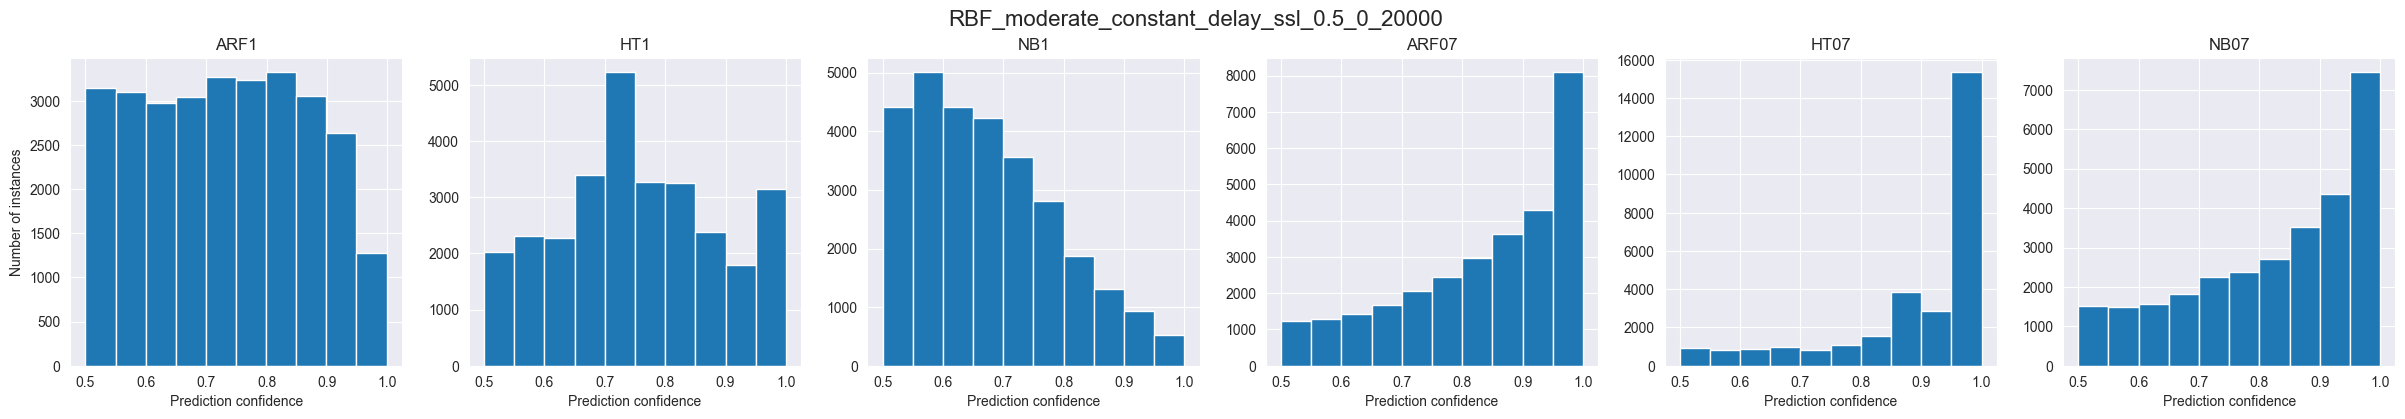

In [63]:
plot_histograms(res)

## Save to latex

In [ ]:
latex_code = table.to_latex(na_rep = '')
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
latex_code = latex_code.replace("\\toprule", "")
latex_code = latex_code.replace("\\midrule", "")
latex_code = latex_code.replace("\\bottomrule", "")
print(latex_code)

C:\Users\gosia\AppData\Local\Temp\ipykernel_43672\417934100.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = table.to_latex(na_rep = '')


\begin{tabular}{llrlll}

{} &   type &  probability &   B\_1 &  B\_45 &  B\_52 \\ \hline

38 &  delay &              &  0.81 &  0.83 &  0.83 \\ \hline
37 &  delay &              &  0.81 &  0.83 &  0.83 \\ \hline
31 &  delay &              &  0.75 &  0.81 &  0.80 \\ \hline
14 &  delay &              &  0.75 &  0.81 &  0.81 \\ \hline
13 &  delay &              &  0.75 &  0.83 &  0.82 \\ \hline
12 &  delay &              &  0.85 &  0.86 &  0.86 \\ \hline
29 &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
27 &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
25 &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
5  &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
3  &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
0  &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
28 &    lfs &          0.1 &  0.00 &  0.00 &  0.87 \\ \hline
26 &    lfs &          0.1 &  0.00 &  0.00 &  0.87 \\ \hline
24 &    lfs &          0.1 &  0.00 &  0.00 &  0.87 \\ \h